In [1]:
# This cell is added by sphinx-gallery
# It can be customized to whatever you like
%matplotlib inline

In [2]:
import pennylane as qml
from pennylane import numpy as np
from matplotlib import pyplot as plt

np.random.seed(42)

# QUBO #
Suppose we have the following QUBO with uncertainty on the linear term $x_2$:
$$
    2 x_0 x_1 + x_0 + c x_1,
$$
where $c$ is equal to -3 or 1 with probability $\frac{1}{2}$.
This means classically we have two QUBOs:
$$
    S_0: 2 x_0 x_1 + x_0 - 3x_1, \;\;\;\; S_1: 2 x_0 x_1 + x_0 + x_1
$$
Using the mapping $x_i \to \frac{1}{2}(\mathbb{I} - Z_i)$, the respective Ising Hamiltonians are:
$$
    H_0: \frac{1}{2} (-1 \mathbb{I} - 2 Z_0 +2 Z_1 + Z_0 Z_1) \;\;\;\; H_1: \frac{1}{2} (3 \mathbb{I} - 2 Z_0 + 2 Z_1 + Z_0 Z_1)
$$
We can combine the Hamiltonians based on the value of $c$:
$$
    H_c: \frac{1}{2} (2 \mathbb{I} - 4 Z_0 + 2 Z_0 Z_1).
$$

In [3]:
x = [1/2 * (qml.Identity(i) - qml.PauliZ(i)) for i in range(2)]

# scenario 0
def obj0(x0, x1):
    if type(x0) == qml.Hamiltonian:
        return 2*x0@x1 + x0 - 3*x1
    else:
        return 2*x0*x1 + x0 - 3*x1
    
H0 = obj0(x[0], x[1])
print(f'H_0 =\n{H0}\n')

# scenario 1
def obj1(x0, x1):
    if type(x0) == qml.Hamiltonian:
        return 2*x0@x1 + x0 + x1
    else:
        return 2*x0*x1 + x0 + x1
H1 = obj1(x[0], x[1])
print(f'H_1 =\n{H1}\n')

# combined
Hc = H0 + H1
print(f'H_c =\n{Hc}\n')

for i in range(2):
    for ii in range(2):
        o0 = obj0(i,ii)
        o1 = obj1(i,ii)
        print(f'x = ({i},{ii}): obj0 = {o0}, obj1 = {o1}, objc = {o0 + o1}')

H_0 =
  (-1.0) [Z0]
+ (-0.5) [I0]
+ (1.0) [Z1]
+ (0.5) [Z0 Z1]

H_1 =
  (-1.0) [Z0]
+ (-1.0) [Z1]
+ (1.5) [I0]
+ (0.5) [Z0 Z1]

H_c =
  (-2.0) [Z0]
+ (1.0) [I0]
+ (1.0) [Z0 Z1]

x = (0,0): obj0 = 0, obj1 = 0, objc = 0
x = (0,1): obj0 = -3, obj1 = 1, objc = -2
x = (1,0): obj0 = 1, obj1 = 1, objc = 2
x = (1,1): obj0 = 0, obj1 = 4, objc = 4


## Testing ##

In [6]:
C = obj1(1/2*(qml.Identity(0)-qml.PauliZ(0)),1/2*(qml.Identity(1)-qml.PauliZ(1)))
Uc = qml.CommutingEvolution(C,1)


for i in range(len(H0.ops)):
    op = C.ops[i]
    coeff = C.coeffs[i]
    print(f'{coeff} * {op}')
    if not op.compare(qml.Identity(0)):
        UC = qml.CommutingEvolution(qml.Hamiltonian([coeff],[op]),1)
        print(qml.ctrl(UC,(2,3),(0,1))
             )

0.5 * PauliZ(wires=[0]) @ PauliZ(wires=[1])
Controlled(CommutingEvolution(1, 0.5, wires=[0, 1]), control_wires=[2, 3], control_values=[False, True])
-1.0 * PauliZ(wires=[0])
Controlled(CommutingEvolution(1, -1.0, wires=[0]), control_wires=[2, 3], control_values=[False, True])
-1.0 * PauliZ(wires=[1])
Controlled(CommutingEvolution(1, -1.0, wires=[1]), control_wires=[2, 3], control_values=[False, True])
1.5 * Identity(wires=[0])


We will need a way to convert a bitstring, representing a sample of
multiple qubits in the computational basis, to integer or base-10 form.


In [7]:
def bitstring_to_int(bit_string_sample):
    bit_string = "".join(str(bs) for bs in bit_string_sample)
    return int(bit_string, base=2)

Here we define the quantum device we are using.

In [8]:
n_wires=2
n_scenarios=2

var = [f'x{i}' for i in range(n_wires)]
scen = [f's{i}' for i in range(n_scenarios)]

# used to remap the wires in the Hamiltonians defined above
wiremap = {}
for i in range(n_wires):
    wiremap[i] = var[i]
    
C = [H0, H1]

sdev = qml.device("default.qubit", wires=var+scen, shots=1)
sdev.wires

<Wires = ['x0', 'x1', 's0', 's1']>

In [9]:
def to_ctrl_val(i, n):
    i = f'{i:0{n}b}'
    ctrl_val = []
    for s in i[::-1]:
        ctrl_val.append(int(s))
    return ctrl_val
for i in range(n_scenarios):
    print(to_ctrl_val(i, n_scenarios))

[0, 0]
[1, 0]


# Gates #
To solve a stochastic QUBO with QAOA, we will use additional scenario qubit(s) as controls for the term in the Hamiltonian that differs.
The *Mixing Hamiltonian* $B = \sum_{i=0}^{n} X_i$ will only apply to the non-scenario qubits.
We implement $B$ as
$$
U(B,\beta) = \exp(-i \beta B) = \prod_{i=0}^n RX_i(2\beta).
$$
The *Cost Hamiltonian* $C$ will be one of $H_0$ and $H_1$ depending on which scenario we are in.
In each case, we will have $U(H_0, \gamma)$ and $U(H_1, \gamma)$.
However, we only want one of these to be applied depending on the scenario we are in.
We can use the scenario qubit $s$ to implement this as controls for each unitary:
$$
    U(C,\gamma) = C_0U(H_0,\gamma) C_1U(H_1,\gamma).
$$

In [10]:
# unitary operator U_B with parameter beta
def U_B(beta):
    for wire in var:
        qml.RX(2 * beta, wires=wire)

# unitary operator U_C with parameter gamma
def U_C(C,gamma,scen):
    for s in range(n_scenarios):
        Cs = C[s].map_wires(wiremap)
        UCs = qml.CommutingEvolution(Cs,gamma)
        qml.ctrl(UCs,
                 control=scen,
                 control_values=to_ctrl_val(2**s,n_scenarios))
    
    

# The Circuit #
Now we build the circuit that solves the stochastic QUBO.
We initalize the variable qubit into the state
$$
|s\rangle = \sum_{z \in \{0,1\}^n} |z\rangle.
$$
We also initalize the scenario qubit in to an equal superposition of the scenarios:
$$
\frac{1}{\sqrt{2}} (|10\rangle + |01\rangle).
$$
Now we apply $p$ alternating layers of $U(C,\gamma)$ (on the variable and scenario qubits) and $U(B,\beta)$ (only on the variable qubits).

In [11]:
#@qml.qnode(dev)
@qml.qnode(sdev)
def circuit(gammas, betas, sample=False, n_layers=1):
    # apply Hadamards to get the n qubit |+> state
    for x in var:
        qml.Hadamard(wires=x)
        
    # initialize scenario qubit
    #qml.Hadamard(wires='s0')
    
    # will be useful when having multiple scenarios
    w_state = np.zeros(2**n_scenarios)
    probs = [1/n_scenarios,1/n_scenarios,1/n_scenarios]
    for i in range(n_scenarios):
        w_state[2**i] = np.sqrt(probs[i])
    qml.MottonenStatePreparation(w_state,wires=scen)
    
    # p instances of unitary operators
    for i in range(n_layers):
        U_C(C,gammas[i],scen)
        U_B(betas[i])
    
    # return samples instead of expectation value
    if sample:
        # measurement phase
        return qml.sample()
    
    # during the optimization phase we are evaluating the objective using expval
    # use Hamiltonian corresponding to scenario
    ## DOES NOT WORK FOR MORE THAN 2 SCENARIOS
    #s = qml.measure(scen)
    #if s == 0:
    #    H = H_0
    #else:
    #    H = H_1
    
    # Currently use the sum of the Cost Hamiltonians.
    H = sum(C)
    return qml.expval(H.map_wires(wiremap))

In [12]:
def sqaoa(n_layers=1):
    print("\np={:d}".format(n_layers))

    # initialize the parameters near zero
    init_params = 0.01 * np.random.rand(2, n_layers, requires_grad=True)

    # minimize the negative of the objective function
    def objective(params):
        gammas = params[0]
        betas = params[1]
        neg_obj = -circuit(gammas, betas,n_layers=n_layers)
        return neg_obj

    # initialize optimizer: Adagrad works well empirically
    opt = qml.AdagradOptimizer(stepsize=0.5)

    # optimize parameters in objective
    params = init_params
    steps = 50
    for i in range(steps):
        params = opt.step(objective, params)
        if (i + 1) % 5 == 0:
            print("Objective after step {:5d}: {: .7f}".format(i + 1, -objective(params)))

    # sample measured bitstrings 100 times
    bit_strings = []
    n_samples = 1000
    for i in range(0, n_samples):
        bit_strings.append(bitstring_to_int(circuit(params[0], params[1], sample=True, n_layers=n_layers)))

    # print optimal parameters and most frequently sampled bitstring
    counts = np.bincount(np.array(bit_strings))
    most_freq_bit_string = np.argmax(counts)
    print("Optimized (gamma, beta) vectors:\n{}".format(params[:, :n_layers]))
    print("Most frequently sampled bit string is: {:03b} with probability {:.4f}".format(most_freq_bit_string,counts[most_freq_bit_string]/n_samples))

    return params, bit_strings

In [13]:
import matplotlib.pyplot as plt

def graph(bitstrings1):
    
    xticks = range(0, 2**(n_wires+n_scenarios))
    xtick_labels = list(map(lambda x: format(x, f"0{n_wires+n_scenarios}b"), xticks))
    bins = np.arange(0, 2**(n_wires+n_scenarios)+1) - 0.5

    plt.figure(figsize=(16, 8))
    plt.rc('font', size=16)
    plt.title("s-QAOA")
    plt.xlabel("Bitstrings")
    plt.ylabel("Frequency")
    plt.xticks(xticks, xtick_labels, rotation="vertical")
    plt.hist([bitstrings1], 
             bins=bins, 
             density=True,
             color=['#286d8c'],
             edgecolor = "#041017",
             label=['s-QAOA'])
    plt.legend()
    plt.tight_layout()
    
    plt.show()

Now we run QAOA and graph the results. Note that the bitstrings are read '$q_0 q_1 s_0 s_1$'.

The optimal result for scenario 0 is $x = (1,0)$ with value $1$, so output bitstring $1010$.

The optimal result for scenario 1 is $x = (1,1)$ with value $4$, so output bitstring $1101$.


p=2
Objective after step     5:  2.0000000
Objective after step    10: -2.0000000
Objective after step    15: -2.0000000
Objective after step    20:  2.0000000
Objective after step    25:  4.0000000
Objective after step    30:  4.0000000
Objective after step    35:  2.0000000
Objective after step    40:  0.0000000
Objective after step    45: -2.0000000
Objective after step    50: -2.0000000
Optimized (gamma, beta) vectors:
[[ 0.07996694 -0.71464364]
 [ 0.86949636 -0.48968742]]
Most frequently sampled bit string is: 1010 with probability 0.4140


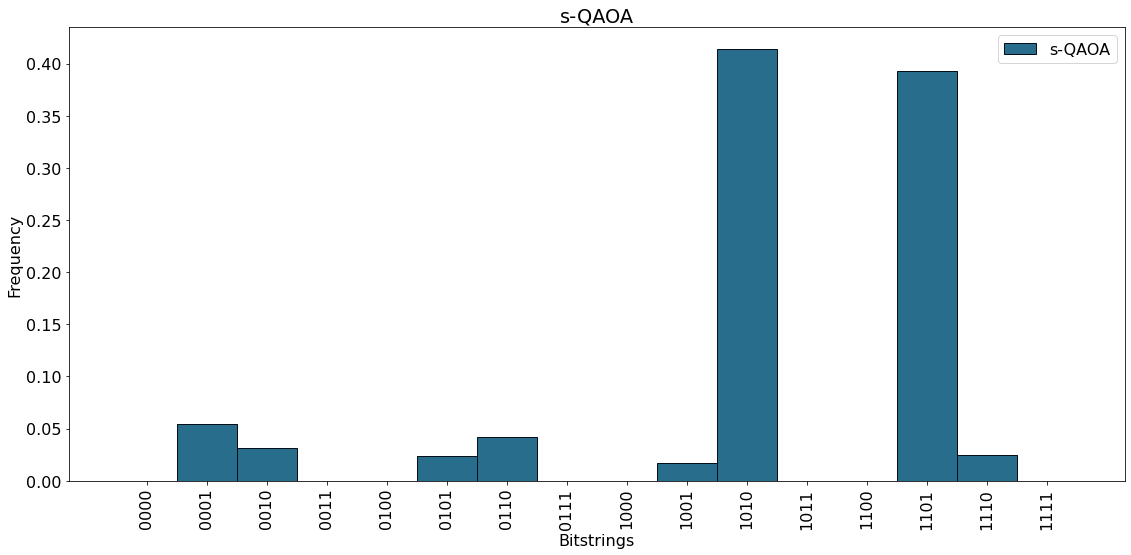

In [14]:
params, bitstrings = sqaoa(n_layers=1)
graph(bitstrings)

In [15]:
for i in range(2):
    for ii in range(2):
        o0 = obj0(i,ii)
        o1 = obj1(i,ii)
        print(f'x = ({i},{ii}): obj0 = {o0}, obj1 = {o1}, objc = {o0 + o1}')

x = (0,0): obj0 = 0, obj1 = 0, objc = 0
x = (0,1): obj0 = -3, obj1 = 1, objc = -2
x = (1,0): obj0 = 1, obj1 = 1, objc = 2
x = (1,1): obj0 = 0, obj1 = 4, objc = 4


In [ ]:
def write_to_latex(angles, name, file):
    pwd = !pwd
    with open(f'{pwd[0]}/{file}','w') as f:
        f.write(f'{name} = \n')
        if len(angles) == 1:
            f.write(f'{angles[0]:.4f}')
        else:
            f.write('\\begin{btmatrix}\n')
            for i in range(len(angles)):
                f.write(f'\t{angles[i][0]:.4f}')
                if i != len(angles) - 1:
                    f.write(' \\\\\n')
            f.write('\n\\end{btmatrix}')             

## Testing ##

In [ ]:
bs = {}

def to_bit_dict(bitstrings, bs):
    bitstrings.sort()
    for i in bitstrings:
        if f'{i:03b}' in bs.keys():
            bs[f'{i:03b}'] += 1
        else:
            bs[f'{i:03b}'] = 1
    return bs
bs = to_bit_dict(bitstrings, bs)
bs

In [ ]:
@qml.qnode(qml.device('default.qubit', wires=range(4)))
def circuit(x):
    qml.Hadamard(wires=0)
    qml.Hadamard(wires=1)
    qml.Hadamard(wires=2)
    qml.Hadamard(wires=3)
    
    qml.PauliX(2)
    qml.ctrl(qml.RX, (1,2,3), control_values=to_ctrl_val(1,3))(x, wires=0)
    return qml.expval(qml.PauliZ(0))
print(qml.draw(circuit)("x"))